# ARMA(p,q) and ARIMA(p,d,q)
# Autoregressive Moving Averages
This section covers <em>Autoregressive Moving Averages</em> (ARMA) and <em>Autoregressive Integrated Moving Averages</em> (ARIMA).

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMA.html'>arima_model.ARMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Moving Average ARMA(p,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.html'>arima_model.ARMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;Class to hold results from fitting an ARMA model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html'>arima_model.ARIMA</a></strong><font color=black>(endog, order[, exog, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;Autoregressive Integrated Moving Average ARIMA(p,d,q) model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.html'>arima_model.ARIMAResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;Class to hold results from fitting an ARIMA model<br>	
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.kalmanf.kalmanfilter.KalmanFilter.html'>kalmanf.kalmanfilter.KalmanFilter</a></strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Kalman Filter code intended for use with the ARMA model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive–moving-average model</font><br>
<strong>
<a href='https://otexts.com/fpp2/non-seasonal-arima.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Non-seasonal ARIMA models</font></div>

## Perform standard imports and load datasets

In [2]:
import numpy as np
import pandas as pd

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load datasets
df1 = pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months (120 days)

df2 = pd.read_csv('TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

## Automate the augmented Dickey-Fuller Test
Since we'll be using it a lot to determine if an incoming time series is stationary, let's write a function that performs the augmented Dickey-Fuller Test.

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

## Autoregressive Moving Average - ARMA(p,q)
In this first section we'll look at a stationary dataset, determine (p,q) orders, and run a forecasting ARMA model fit to the data. In practice it's rare to find stationary data with no trend or seasonal component, but the first four months of the <em>Daily Total Female Births</em> dataset should work for our purposes.

#### Dataset should be STATIONARY in order to be used for ARMA

### Plot the source data

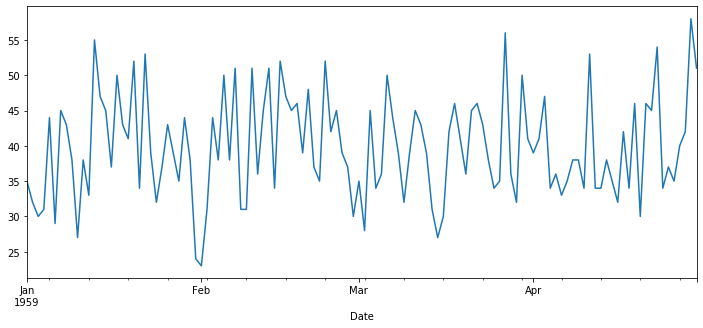

In [5]:
df1['Births'].plot(figsize=(12,5));

### Run the augmented Dickey-Fuller Test to confirm stationarity

In [6]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [7]:
auto_arima(df1['Births'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                        SARIMAX   Log Likelihood                -409.745
Date:                Wed, 31 Mar 2021   AIC                            823.489
Time:                        10:26:19   BIC                            829.064
Sample:                             0   HQIC                           825.753
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.7833      0.687     57.896      0.000      38.437      41.130
sigma2        54.1197      8.319      6.506      0.000      37.815      70.424
===================================================================================
Ljung-Box (Q):                       44.41   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.29   Prob(JB):                         0.26
Heteroskedasticity (H):               0.80   Skew:                             0.26
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Split the data into train/test sets
As a general rule you should set the length of your test set equal to your intended forecast size. For this dataset we'll attempt a 1-month forecast.

In [8]:
train = df1.iloc[:90]
test = df1.iloc[90:]

### Fit an ARMA(p,q) Model
If you want you can run <tt>help(ARMA)</tt> to learn what incoming arguments are available/expected, and what's being retu

In [9]:
model= ARMA(train['Births'],order=(2,2))

In [10]:
fitted_model = model.fit()

In [11]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Wed, 31 Mar 2021   AIC                            627.809
Time:                        10:27:50   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.499      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.800      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.556      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7433           +0.0000j            1.7433            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

### Obtain a month's worth of predicted values

In [12]:
# Obtain a month score of Predicted values.
start=len(train)
end = len(train) + len(test) - 1

In [13]:
predictions= fitted_model.predict(start,end).rename('ARMA ( 2,2) Predictions')

In [15]:
test.head()

,Births
Date,
1959-04-01,39
1959-04-02,41
1959-04-03,47
1959-04-04,34
1959-04-05,36


In [17]:
test.tail()

,Births
Date,
1959-04-26,35
1959-04-27,40
1959-04-28,42
1959-04-29,58
1959-04-30,51


In [16]:
predictions.head()

1959-04-01    39.982215
1959-04-02    39.992615
1959-04-03    39.809827
1959-04-04    39.848174
1959-04-05    39.761536
Freq: D, Name: ARMA ( 2,2) Predictions, dtype: float64

In [18]:
predictions.tail()

1959-04-26    39.754970
1959-04-27    39.754828
1959-04-28    39.754935
1959-04-29    39.754854
1959-04-30    39.754916
Freq: D, Name: ARMA ( 2,2) Predictions, dtype: float64

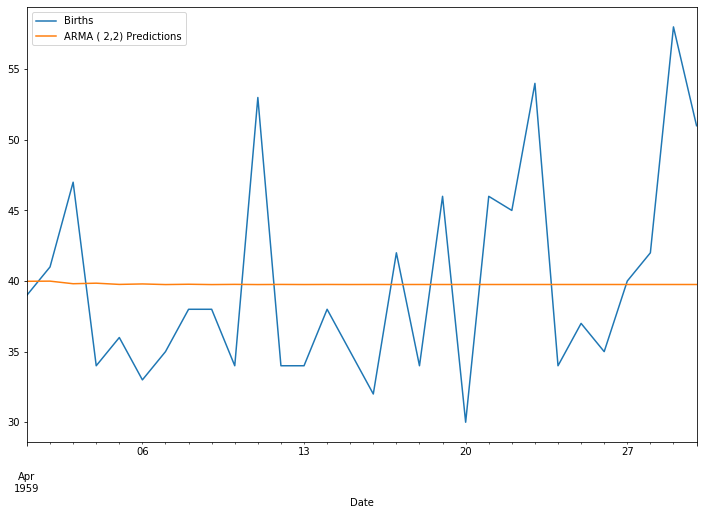

In [20]:
test['Births'].plot(figsize=(12,8),legend = True)
predictions.plot(figsize=(12,8),legend = True)

In [21]:
test.mean()

Births    39.833333
dtype: float64

In [22]:
predictions.mean()

39.77743173952011

Since our starting dataset exhibited no trend or seasonal component, this prediction makes sense. In the next section we'll take additional steps to evaluate the performance of our predictions, and forecast into the future.

# ARIMA

___
## Autoregressive Integrated Moving Average - ARIMA(p,d,q)
The steps are the same as for ARMA(p,q), except that we'll apply a differencing component to make the dataset stationary.<br>
First let's take a look at the <em>Real Manufacturing and Trade Inventories</em> dataset.
### Plot the Source Data

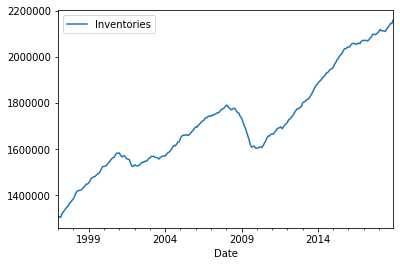

In [23]:
df2.plot()

# Running an ETS Decomposition

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [26]:
result = seasonal_decompose(df2['Inventories'],model='add')

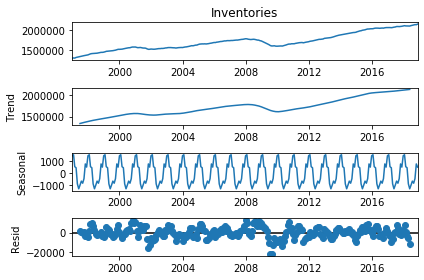

In [28]:
result.plot();

<strong>
Here we see that the seasonal component does not contribute significantly to the behavior of the series.
Use <tt>pmdarima.auto_arima</tt> to determine ARIMA Orders

In [29]:
auto_arima(df2['Inventories'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Wed, 31 Mar 2021   AIC                           5348.037
Time:                        10:45:27   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (Q):                      455.75   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Run the augmented Dickey-Fuller Test on the First Difference